<a href="https://colab.research.google.com/github/PKopel/mpr/blob/cuda/CUDA_lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip CUDA-Lab02.zip

Archive:  CUDA-Lab02.zip
   creating: CUDA-Lab02/
  inflating: CUDA-Lab02/aerosmith-double.pgm  
  inflating: CUDA-Lab02/image_scaling.cu  
  inflating: CUDA-Lab02/matrix_transpose.cu  
  inflating: CUDA-Lab02/matrix_transpose_2.cu  
  inflating: CUDA-Lab02/scrImagePgmPpmPackage.cpp  
  inflating: CUDA-Lab02/scrImagePgmPpmPackage.h  
  inflating: CUDA-Lab02/voyager2.pgm  


In [ ]:
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Mon Jun  6 22:32:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |            

In [ ]:
%%writefile gputimer.h
#ifndef __GPU_TIMER_H__
#define __GPU_TIMER_H__

class GpuTimer
{
    public:
      cudaEvent_t start;
      cudaEvent_t stop;
 
      GpuTimer()
      {
            cudaEventCreate(&start);
            cudaEventCreate(&stop);
      }
 
      ~GpuTimer()
      {
            cudaEventDestroy(start);
            cudaEventDestroy(stop);
      }
 
      void Start()
      {
            cudaEventRecord(start, 0);
      }
 
      void Stop()
      {
            cudaEventRecord(stop, 0);
      }
 
      float Elapsed()
      {
            float elapsed;
            cudaEventSynchronize(stop);
            cudaEventElapsedTime(&elapsed, start, stop);
            return elapsed;
      }
};

#endif  /* __GPU_TIMER_H__ */

Writing gputimer.h


# Transpozycja macierzy

In [ ]:
%%writefile matrix_transpose.cu 
#include<stdio.h>
#include<stdlib.h>
#include "gputimer.h"

__global__ void matrix_transpose_naive(int N, int *input, int *output) {

	int indexX = threadIdx.x + blockIdx.x * blockDim.x;
	int indexY = threadIdx.y + blockIdx.y * blockDim.y;
	int index = indexY * N + indexX;
	int transposedIndex = indexX * N + indexY;

    // this has discoalesced global memory store  
	output[transposedIndex] = input[index];

	// this has discoalesced global memore load
	// output[index] = input[transposedIndex];
}

__global__ void matrix_transpose_shared(int N, int *input, int *output) {

	extern __shared__ int sharedMemory [];

	int indexX = threadIdx.x + blockIdx.x * blockDim.x;
	int indexY = threadIdx.y + blockIdx.y * blockDim.y;
	int index = indexY * N + indexX;
	int transposedIndex = indexX * N + indexY;

	// global index	
	// int indexX = threadIdx.x + blockIdx.x * blockDim.x;
	// int indexY = threadIdx.y + blockIdx.y * blockDim.y;

	// transposed global memory index
	// int tindexX = threadIdx.x + blockIdx.y * blockDim.x;
	// int tindexY = threadIdx.y + blockIdx.x * blockDim.y;

	// local index
	// int localIndexX = threadIdx.x;
	// int localIndexY = threadIdx.y;

	// int index = indexY * N + indexX;
	// int transposedIndex = tindexY * N + tindexX;

	// reading from global memory in coalesed manner and performing tanspose in shared memory
	//sharedMemory[localIndexX][localIndexY] = input[index];
  sharedMemory[index] = input[index];

	__syncthreads();

	// writing into global memory in coalesed fashion via transposed data in shared memory
	// output[transposedIndex] = sharedMemory[localIndexY][localIndexX];
  output[transposedIndex] = sharedMemory[index];
}

//basically just fills the array with index.
void fill_array(int N, int *data) {
	for(int idx=0;idx<(N*N);idx++)
		data[idx] = idx;
}

void print_output(int N, int *a, int *b) {
	printf("\n Original Matrix::\n");
	for(int idx=0;idx<(N*N);idx++) {
		if(idx%N == 0)
			printf("\n");
		printf(" %d ",  a[idx]);
	}
	printf("\n Transposed Matrix::\n");
	for(int idx=0;idx<(N*N);idx++) {
		if(idx%N == 0)
			printf("\n");
		printf(" %d ",  b[idx]);
	}
}

int main(int argc, char *argv[]) {
    
  if (argc < 3) {
    exit(1);
  }
  int BLOCK_SIZE = atoi(argv[1]);
  int N = atoi(argv[2]);

  printf("%d,%d", N, BLOCK_SIZE);
	
  int *a, *b;
  int *d_a, *d_b; // device copies of a, b, c

	int size = N * N *sizeof(int);

	// Alloc space for host copies of a, b, c and setup input values
	a = (int *)malloc(size); fill_array(N, a);
	b = (int *)malloc(size);

	// Alloc space for device copies of a, b, c
	cudaMalloc((void **)&d_a, size);
	cudaMalloc((void **)&d_b, size);

	// Copy inputs to device
	cudaMemcpy(d_a, a, size, cudaMemcpyHostToDevice);
	cudaMemcpy(d_b, b, size, cudaMemcpyHostToDevice);

	dim3 blockSize(BLOCK_SIZE,BLOCK_SIZE,1);
	dim3 gridSize(N/BLOCK_SIZE,N/BLOCK_SIZE,1);

  GpuTimer timer;
  timer.Start();

	matrix_transpose_naive<<<gridSize,blockSize>>>(N, d_a,d_b);
	    
  cudaDeviceSynchronize();
    
  timer.Stop();
  printf(",%f", timer.Elapsed());

	// Copy result back to host
	// cudaMemcpy(b, d_b, size, cudaMemcpyDeviceToHost);
	// print_output(a,b);

  timer.Start();

	matrix_transpose_shared<<<gridSize,blockSize, size>>>(N, d_a,d_b);
	    
  cudaDeviceSynchronize();
    
  timer.Stop();
  printf(",%f\n", timer.Elapsed());

	// Copy result back to host
	cudaMemcpy(b, d_b, size, cudaMemcpyDeviceToHost);
	// print_output(a,b);

	// terminate memories
	free(a);
	free(b);
  cudaFree(d_a);
	cudaFree(d_b); 

	return 0;
}

Overwriting matrix_transpose.cu


In [ ]:
!nvcc -o matrix_transpose matrix_transpose.cu 

running: `./matrix_transpose <#threads> <size>`

In [ ]:
%%writefile run.sh
#!/usr/bin/env bash

echo "size,threads,naive,shared" > results_1.csv

for i in 16 32 64; do
  ./matrix_transpose $i 2048 >> results_1.csv
done

for i in 1024 2048 4096; do
  ./matrix_transpose 32 $i >> results_1.csv
done


Overwriting run.sh


In [ ]:
!chmod +x run.sh
!./run.sh

In [ ]:
%%writefile matrix_transpose_2.cu 
#include<stdio.h>
#include<stdlib.h>
#include "gputimer.h"

#define N 4096
#define BLOCK_SIZE 32

__global__ void matrix_transpose_naive(int *input, int *output) {

	int indexX = threadIdx.x + blockIdx.x * blockDim.x;
	int indexY = threadIdx.y + blockIdx.y * blockDim.y;
	int index = indexY * N + indexX;
	int transposedIndex = indexX * N + indexY;

	// this has discoalesced global memory store  
	output[transposedIndex] = input[index];

	// this has discoalesced global memore load
	// output[index] = input[transposedIndex];
}

__global__ void matrix_transpose_shared(int *input, int *output) {

	__shared__ int sharedMemory [BLOCK_SIZE] [BLOCK_SIZE + 1];

	// global index	
	int indexX = threadIdx.x + blockIdx.x * blockDim.x;
	int indexY = threadIdx.y + blockIdx.y * blockDim.y;

	// transposed global memory index
	int tindexX = threadIdx.x + blockIdx.y * blockDim.x;
	int tindexY = threadIdx.y + blockIdx.x * blockDim.y;

	// local index
	int localIndexX = threadIdx.x;
	int localIndexY = threadIdx.y;

	int index = indexY * N + indexX;
	int transposedIndex = tindexY * N + tindexX;

	// reading from global memory in coalesed manner and performing tanspose in shared memory
	sharedMemory[localIndexX][localIndexY] = input[index];

	__syncthreads();

	// writing into global memory in coalesed fashion via transposed data in shared memory
	output[transposedIndex] = sharedMemory[localIndexY][localIndexX];
}

//basically just fills the array with index.
void fill_array(int *data) {
	for(int idx=0;idx<(N*N);idx++)
		data[idx] = idx;
}

void print_output(int *a, int *b) {
	printf("\n Original Matrix::\n");
	for(int idx=0;idx<(N*N);idx++) {
		if(idx%N == 0)
			printf("\n");
		printf(" %d ",  a[idx]);
	}
	printf("\n Transposed Matrix::\n");
	for(int idx=0;idx<(N*N);idx++) {
		if(idx%N == 0)
			printf("\n");
		printf(" %d ",  b[idx]);
	}
}

int main(void) {
  printf("%d,%d", N, BLOCK_SIZE);
	
  int *a, *b;
  int *d_a, *d_b; // device copies of a, b, c

	int size = N * N *sizeof(int);

	// Alloc space for host copies of a, b, c and setup input values
	a = (int *)malloc(size); fill_array(a);
	b = (int *)malloc(size);

	// Alloc space for device copies of a, b, c
	cudaMalloc((void **)&d_a, size);
	cudaMalloc((void **)&d_b, size);

	// Copy inputs to device
	cudaMemcpy(d_a, a, size, cudaMemcpyHostToDevice);
	cudaMemcpy(d_b, b, size, cudaMemcpyHostToDevice);

	dim3 blockSize(BLOCK_SIZE,BLOCK_SIZE,1);
	dim3 gridSize(N/BLOCK_SIZE,N/BLOCK_SIZE,1);

  GpuTimer timer;
  timer.Start();

	matrix_transpose_naive<<<gridSize,blockSize>>>(d_a,d_b);
	    
  cudaDeviceSynchronize();
    
  timer.Stop();
  printf(",%f", timer.Elapsed());

	// Copy result back to host
	// cudaMemcpy(b, d_b, size, cudaMemcpyDeviceToHost);
	// print_output(a,b);

  timer.Start();

	matrix_transpose_shared<<<gridSize,blockSize>>>(d_a,d_b);
	    
  cudaDeviceSynchronize();
    
  timer.Stop();
  printf(",%f", timer.Elapsed());

	// Copy result back to host
	cudaMemcpy(b, d_b, size, cudaMemcpyDeviceToHost);
	// print_output(a,b);

	// terminate memories
	free(a); 
	free(b);
  cudaFree(d_a); 
	cudaFree(d_b); 

	return 0;
}

Overwriting matrix_transpose_2.cu


In [ ]:
!nvcc -o matrix_transpose_2 matrix_transpose_2.cu 

In [ ]:
!echo "size,threads,naive,shared" > results_2.csv

In [ ]:
!./matrix_transpose_2 >> results_2.csv

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [ ]:
results = pd.read_csv('results_1.csv')
results

,size,threads,naive,shared
0,2048,16,0.318688,0.007840
1,2048,32,0.754400,0.008128
2,2048,64,0.009312,0.007936
3,1024,32,0.204608,0.007648
4,2048,32,0.755008,0.008192
5,4096,32,2.942016,0.008032


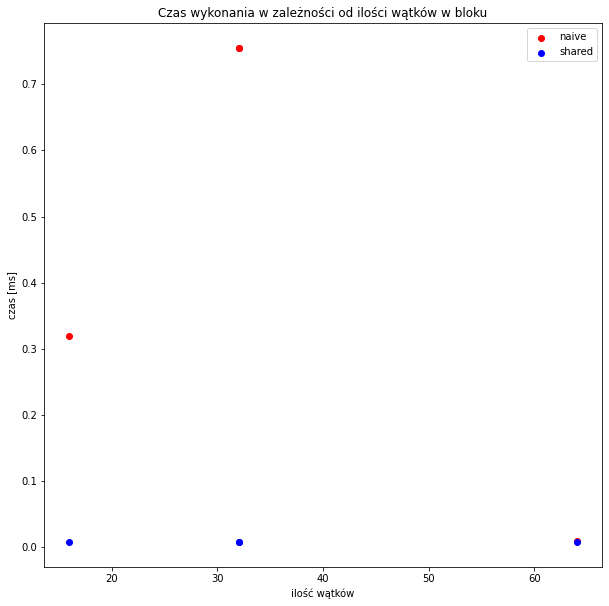

In [ ]:
plt.figure(figsize=(10,10))

by_threads = results[ results['size'] == 2048]

plt.scatter(by_threads['threads'],by_threads['naive'],c='r',label='naive')
plt.scatter(by_threads['threads'],by_threads['shared'],c='b',label='shared')

plt.legend()
plt.title(f'Czas wykonania w zależności od ilości wątków w bloku')
plt.xlabel('ilość wątków')
plt.ylabel(f'czas [ms]')
plt.show()

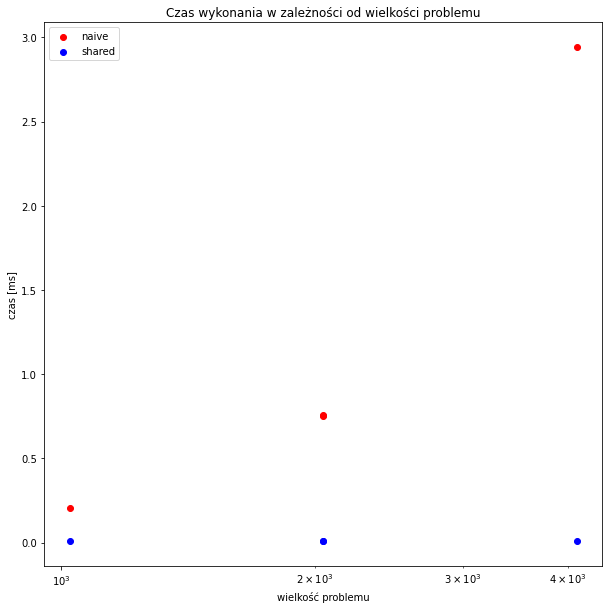

In [ ]:
plt.figure(figsize=(10,10))

by_threads = results[ results['threads'] == 32]

plt.scatter(by_threads['size'],by_threads['naive'],c='r',label='naive')
plt.scatter(by_threads['size'],by_threads['shared'],c='b',label='shared')

plt.legend()
plt.title(f'Czas wykonania w zależności od wielkości problemu')
plt.xlabel('wielkość problemu')
plt.ylabel(f'czas [ms]')
plt.xscale('log')
plt.show()

In [ ]:
results = pd.read_csv('results_2.csv')
results

,size,threads,naive,shared
0,2048,16,0.317728,0.193600
1,2048,32,0.756192,0.210624
2,2048,64,0.008896,0.007744
3,1024,32,0.205024,0.061600
4,2048,32,0.751776,0.210912
5,4096,32,2.935872,0.801088


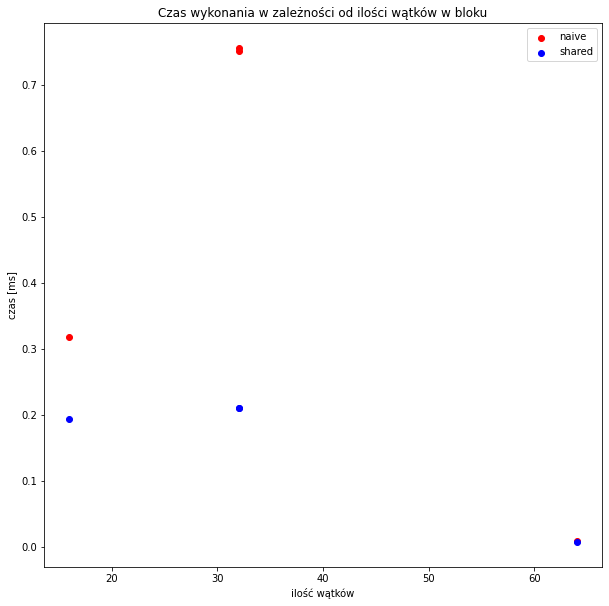

In [ ]:
plt.figure(figsize=(10,10))

by_threads = results[ results['size'] == 2048]

plt.scatter(by_threads['threads'],by_threads['naive'],c='r',label='naive')
plt.scatter(by_threads['threads'],by_threads['shared'],c='b',label='shared')

plt.legend()
plt.title(f'Czas wykonania w zależności od ilości wątków w bloku')
plt.xlabel('ilość wątków')
plt.ylabel(f'czas [ms]')
plt.show()

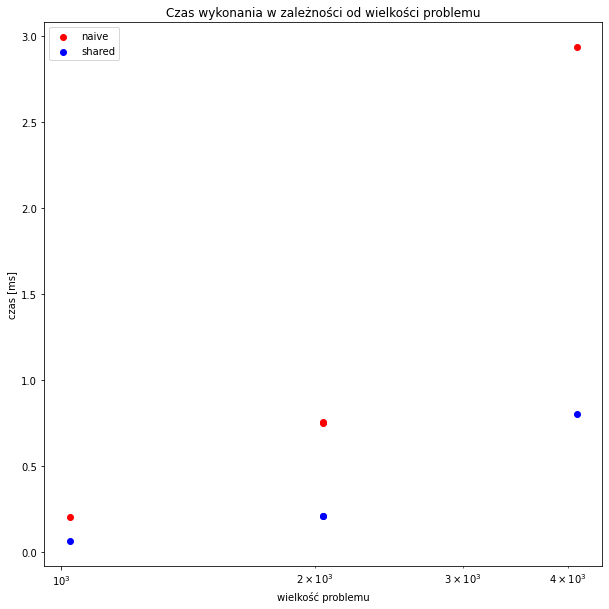

In [ ]:
plt.figure(figsize=(10,10))

by_threads = results[ results['threads'] == 32]

plt.scatter(by_threads['size'],by_threads['naive'],c='r',label='naive')
plt.scatter(by_threads['size'],by_threads['shared'],c='b',label='shared')

plt.legend()
plt.title(f'Czas wykonania w zależności od wielkości problemu')
plt.xlabel('wielkość problemu')
plt.ylabel(f'czas [ms]')
plt.xscale('log')
plt.show()

# Image scaling

In [ ]:
%%writefile image_scaling.cu
#include <stdio.h>
#include <stdlib.h>
#include "CUDA-Lab02/scrImagePgmPpmPackage.h"
#include "gputimer.h"

//Kernel which calculate the resized image
__global__ void createResizedImage(unsigned char *imageScaledData, int scaled_width, float scale_factor, cudaTextureObject_t texObj)
{
	const unsigned int tidX = blockIdx.x * blockDim.x + threadIdx.x;
	const unsigned int tidY = blockIdx.y * blockDim.y + threadIdx.y;
	const unsigned index = tidY * scaled_width + tidX;
       	
	// Step 4: Read the texture memory from your texture reference in CUDA Kernel
	// printf("index: %d\n", index);
	imageScaledData[index] = tex2D<unsigned char>(texObj,(float)(tidX * scale_factor),(float)(tidY * scale_factor));
}

int main(int argc, char*argv[])
{
	int height=0, width =0, scaled_height=0,scaled_width=0;
	//Define the scaling ratio	
	float scaling_ratio=2.0;
	unsigned char*data;
	unsigned char*scaled_data,*d_scaled_data;

  int BLOCK_SIZE = atoi(argv[1]);
	char* inputStr = argv[2];
	char outputStr[1024] = {"double-scaled.pgm"};
	cudaError_t returnValue;

	//Create a channel Description to be used while linking to the tecture
	cudaArray* cu_array;
	cudaChannelFormatKind kind = cudaChannelFormatKindUnsigned;
	cudaChannelFormatDesc channelDesc = cudaCreateChannelDesc(8, 0, 0, 0, kind);

	get_PgmPpmParams(inputStr, &height, &width);	//getting height and width of the current image
	data = (unsigned char*)malloc(height*width*sizeof(unsigned char));
	// printf("\n Reading image width height and width [%d][%d]", height, width);
	scr_read_pgm( inputStr , data, height, width );//loading an image to "inputimage"

	scaled_height = (int)(height*scaling_ratio);
	scaled_width = (int)(width*scaling_ratio);
	scaled_data = (unsigned char*)malloc(scaled_height*scaled_width*sizeof(unsigned char));
	// printf("\n scaled image width height and width [%d][%d]", scaled_height, scaled_width);

	//Allocate CUDA Array
 	returnValue = cudaMallocArray( &cu_array, &channelDesc, width, height);
	// printf("\n%s", cudaGetErrorString(returnValue));
	// cudaMemcpyToArray()
	returnValue = (cudaError_t)(returnValue | cudaMemcpyToArray( cu_array, 0, 0, data, height * width * sizeof(unsigned char), cudaMemcpyHostToDevice));
	// printf("\n%s", cudaGetErrorString(returnValue));

	// if(returnValue != cudaSuccess)
	//	 printf("\n Got error while running CUDA API Array Copy");

	// Step 1. Specify texture
	struct cudaResourceDesc resDesc;
	memset(&resDesc, 0, sizeof(resDesc));
	resDesc.resType = cudaResourceTypeArray;
	resDesc.res.array.array = cu_array;

	// Step 2. Specify texture object parameters
	struct cudaTextureDesc texDesc;
	memset(&texDesc, 0, sizeof(texDesc));
	texDesc.addressMode[0] = cudaAddressModeClamp;
	texDesc.addressMode[1] = cudaAddressModeClamp;
	texDesc.filterMode = cudaFilterModePoint;
	texDesc.readMode = cudaReadModeElementType;
	texDesc.normalizedCoords = 0;

	// Step 3: Create texture object
	cudaTextureObject_t texObj = 0;
	cudaCreateTextureObject(&texObj, &resDesc, &texDesc, NULL);

	// if(returnValue != cudaSuccess) 
	//   printf("\n Got error while running CUDA API Bind Texture");
	
	cudaMalloc(&d_scaled_data, scaled_height*scaled_width*sizeof(unsigned char) );

	dim3 dimBlock(BLOCK_SIZE, BLOCK_SIZE, 1);
	dim3 dimGrid(scaled_width / dimBlock.x + 1, scaled_height / dimBlock.y + 1, 1);
	// printf("\n Launching grid with blocks [%d][%d] ", dimGrid.x,dimGrid.y);
 
  GpuTimer timer;
  timer.Start();

	createResizedImage<<<dimGrid, dimBlock>>>(d_scaled_data, scaled_width, 1.0 / scaling_ratio, texObj);
	    
  cudaDeviceSynchronize();
    
  timer.Stop();
  printf("%s,%d,%f\n", inputStr, BLOCK_SIZE, timer.Elapsed());

	returnValue = (cudaError_t)(returnValue | cudaDeviceSynchronize());

	returnValue = (cudaError_t)(returnValue |cudaMemcpy (scaled_data , d_scaled_data, scaled_height*scaled_width*sizeof(unsigned char), cudaMemcpyDeviceToHost ));
	// if(returnValue != cudaSuccess) 
	//   printf("\n Got error while running CUDA API kernel");

	// Step 5: Destroy texture object
	cudaDestroyTextureObject(texObj);
	
	scr_write_pgm( outputStr, scaled_data, scaled_height, scaled_width, "####" ); //storing the image with the detections
		
	if(data != NULL)
		free(data);
	if(cu_array !=NULL)
		cudaFreeArray(cu_array);
	if(scaled_data != NULL)
		free(scaled_data);
	if(d_scaled_data!=NULL)
		cudaFree(d_scaled_data);
	
	return 0;
}

Overwriting image_scaling.cu


In [ ]:
!nvcc -o image_scaling image_scaling.cu CUDA-Lab02/scrImagePgmPpmPackage.cpp 

image_scaling.cu(103): warning: conversion from a string literal to "char *" is deprecated

image_scaling.cu(103): warning: conversion from a string literal to "char *" is deprecated

image_scaling.cu: In function ‘int main(int, char**)’:
image_scaling.cu:50:149: warning: ‘cudaError_t cudaMemcpyToArray(cudaArray_t, size_t, size_t, const void*, size_t, cudaMemcpyKind)’ is deprecated [-Wdeprecated-declarations]
  returnValue = (cudaError_t)(returnValue | cudaMemcpyToArray( cu_array, 0, 0, data, height * width * sizeof(unsigned char), cudaMemcpyHostToDevice));
                                                                                                                                                     ^
/usr/local/cuda/bin/../targets/x86_64-linux/include/cuda_runtime_api.h:7108:46: note: declared here
 extern __CUDA_DEPRECATED __host__ cudaError_t CUDARTAPI cudaMemcpyToArray(cudaArray_t dst, size_t wOffset, size_t hOffset, const void *src, size_t count, enum cudaMemcpyKind kind);
   

running: `/image_scaling <#threads> <image path>`




In [ ]:
!./image_scaling 32 CUDA-Lab02/aerosmith-double.pgm

CUDA-Lab02/aerosmith-double.pgm,32,0.042656


In [ ]:
%%writefile run.sh
#!/usr/bin/env bash

echo "image,threads,time" > results.csv

for i in "aerosmith-double.pgm" "voyager2.pgm" ; do
  for t in 16 32 64; do
    ./image_scaling $t "CUDA-Lab02/$i" >> results.csv
  done
done


Overwriting run.sh


In [ ]:
!chmod +x run.sh
!./run.sh

In [ ]:
results = pd.read_csv('results.csv')
results

,image,threads,time
0,CUDA-Lab02/aerosmith-double.pgm,16,0.036704
1,CUDA-Lab02/aerosmith-double.pgm,32,0.039616
2,CUDA-Lab02/aerosmith-double.pgm,64,0.009184
3,CUDA-Lab02/voyager2.pgm,16,0.078720
4,CUDA-Lab02/voyager2.pgm,32,0.092544
5,CUDA-Lab02/voyager2.pgm,64,0.008928


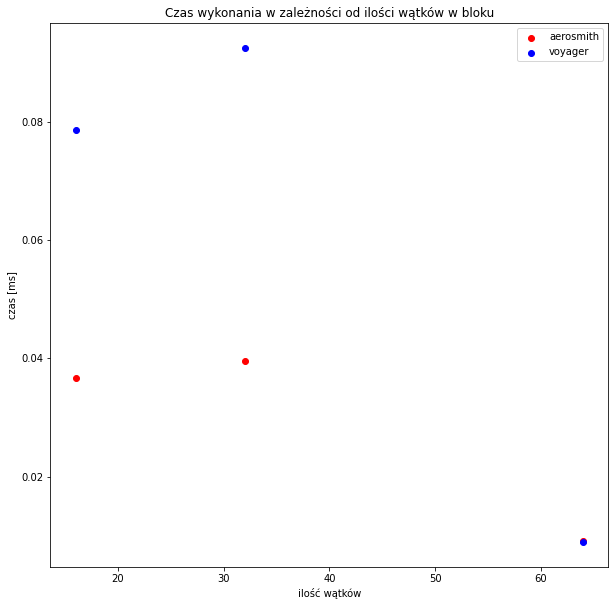

In [ ]:
plt.figure(figsize=(10,10))

aerosmith = results[ results['image'] == 'CUDA-Lab02/aerosmith-double.pgm']
voyager = results[ results['image'] == 'CUDA-Lab02/voyager2.pgm']

plt.scatter(aerosmith['threads'],aerosmith['time'],c='r',label='aerosmith')
plt.scatter(voyager['threads'],voyager['time'],c='b',label='voyager')

plt.legend()
plt.title(f'Czas wykonania w zależności od ilości wątków w bloku')
plt.xlabel('ilość wątków')
plt.ylabel(f'czas [ms]')
plt.show()